Disclaimer: All the computation times are calculated on our computers so they can change but the proportions should remain the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import laplacian_kernel,rbf_kernel
from sklearn.model_selection import GridSearchCV
import time


**A)** We chose 30 and 0 as our two classes.

In [2]:

orientations_train=np.load("orientations_train.npy")

indices=[]
y=[]
for i in range(len(orientations_train)):
    if(orientations_train[i]==30 or orientations_train[i]==0):
        indices.append(i)
        y.append(orientations_train[i])

y=np.array(y)/15-1
X=[]
for i in indices:
    a= Image.open("3dshapes_train/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    # portions of the image we used as feature
    crop_left=image_array[12:30,0:10]  
    crop_right=image_array[12:30,54:64] 
    flattened_crop_left=crop_left.flatten()
    flattened_crop_right=crop_right.flatten()
    flattened_crop=np.concatenate((flattened_crop_left,flattened_crop_right))
    X.append(flattened_crop)
    
X=np.array(X)

orientations_test=np.load("orientations_test.npy")
indices_test=[]
y_test=[]
for i in range(len(orientations_test)):
    if(orientations_test[i]==30 or orientations_test[i]==0):
        indices_test.append(i)
        y_test.append(orientations_test[i])
y_test=np.array(y_test)/15-1
X_test=[]
for i in indices_test:
    a= Image.open("3dshapes_test/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    crop_left=image_array[12:30,0:10]  
    crop_right=image_array[12:30,54:64] 
    flattened_crop_left=crop_left.flatten()
    flattened_crop_right=crop_right.flatten()
    flattened_crop=np.concatenate((flattened_crop_left,flattened_crop_right))
    X_test.append(flattened_crop)

X_test=np.array(X_test)

We used grid search as our strategy to tune the hyperparameters. There are different parameter grids for lda case because the range of the input values change after lda. "Only c" grid is for soft margin linear model since it has no gamma paramter to tune. "Only gamma" grid is for hard margin polynomial and hard margin rbf models since we can't change C for hard margin.

In [3]:
st=time.time()
param_grid = {'gamma': [0.01, 0.1, 1], 'C': [1, 10, 100]}
param_grid_only_c={"C": [1,10,100]}
param_grid_only_gamma={"gamma": [0.01, 0.1, 1]}
param_grid_lda= {'gamma': [0.00001,0.0001, 0.001], 'C': [1, 10, 100]}
param_grid_lda_only_gamma={"gamma": [0.00001, 0.0001, 0.001]}
svcBinary_Classifier=SVC(kernel="linear")
grid_search= GridSearchCV(svcBinary_Classifier,param_grid_only_c,cv=5)
grid_search.fit(X,y)
et=time.time()
print("Computation time: ", (et-st),"seconds")

Computation time:  0.1100001335144043 seconds


In [4]:
y_prediction = grid_search.predict(X_test)
print("Best parameters: ", grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Best parameters:  {'C': 1}
Test accuracy:  1.0


In [5]:
X_multi=[]

for i in range(10000):
    a= Image.open("3dshapes_train/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    # portions of the image we used as feature
    crop_left=image_array[12:30,0:10]  
    crop_right=image_array[12:30,54:64] 
    flattened_crop_left=crop_left.flatten()
    flattened_crop_right=crop_right.flatten()
    flattened_crop=np.concatenate((flattened_crop_left,flattened_crop_right))
    X_multi.append(flattened_crop)

X_multi=np.array(X_multi)
y_multi=orientations_train*14/60+7  # to turn classes into 0,1,2,... 14

X_multi_test=[]
for i in range(1000):
    a= Image.open("3dshapes_test/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    crop_left=image_array[12:30,0:10]  
    crop_right=image_array[12:30,54:64] 
    flattened_crop_left=crop_left.flatten()
    flattened_crop_right=crop_right.flatten()
    flattened_crop=np.concatenate((flattened_crop_left,flattened_crop_right))
    X_multi_test.append(flattened_crop)

X_multi_test=np.array(X_multi_test)
y_multi_test=orientations_test*14/60+7

In [6]:
st=time.time()
svcMulti_Classifier=SVC(kernel="linear")
grid_search= GridSearchCV(svcMulti_Classifier,param_grid_only_c,cv=5)
grid_search.fit(X_multi,y_multi)
et=time.time()

print("Computation time: ", (et-st), "seconds")

Computation time:  4.959575891494751 seconds


Computation time for the multi class case is much higher than the binary class case. This is because when there are 15 class multi classification problem, 15.14/2 binary classifiers are created and trained (one versus one approach). 

In [7]:
y_prediction = grid_search.predict(X_multi_test)
print("Best C value: ", grid_search.best_params_['C'])
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Best C value:  1
Test accuracy:  1.0


**B)  Binary with original features section**

In [8]:
st=time.time()
Soft_margin_b=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_b,param_grid_only_c,cv=5)
grid_search.fit(X,y)

y_prediction = grid_search.predict(X_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_b=SVC(C=1e10,kernel="linear")
Hard_margin_b.fit(X,y)

y_prediction=Hard_margin_b.predict(X_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Soft_margin_poly_b=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_b,param_grid,cv=5)
grid_search.fit(X,y)

y_prediction = grid_search.predict(X_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_poly_b=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_b,param_grid_only_gamma,cv=5)
grid_search.fit(X,y)

y_prediction = grid_search.predict(X_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Soft_margin_rbf_b=SVC(kernel="rbf")
grid_search= GridSearchCV(Soft_margin_rbf_b,param_grid,cv=5)
grid_search.fit(X,y)

y_prediction = grid_search.predict(X_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_rbf_b=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_b,param_grid_only_gamma,cv=5)
grid_search.fit(X,y)

y_prediction = grid_search.predict(X_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

et=time.time()
print("Computation time: ", et-st," seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Computation time:  0.9297189712524414  seconds


For the laplacian kernel we couldn't use grid search because laplacian is not one of the choices for kernel function in SVMs.
So we decided on gamma ourselves by taking the range of the input values into account.

In [9]:
st=time.time()

gram_train=laplacian_kernel(X,gamma=1)
gram_test=laplacian_kernel(X_test,X,gamma=1)


et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.3045082092285156 seconds


In [10]:
st=time.time()
Soft_margin_laplace_b=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_b.fit(gram_train,y)

Hard_margin_laplace_b=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_b.fit(gram_train,y)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.006806135177612305 seconds


In [11]:

y_prediction=Soft_margin_laplace_b.predict(gram_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

y_prediction=Hard_margin_laplace_b.predict(gram_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Test accuracy:  1.0
Test accuracy:  1.0


**Multi class with original features section**

In [12]:
st=time.time()
Soft_margin_m=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_m,param_grid_only_c,cv=5)
grid_search.fit(X_multi,y_multi)

y_prediction = grid_search.predict(X_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_m=SVC(C=1e10,kernel="linear")
Hard_margin_m.fit(X_multi,y_multi)

y_prediction=Hard_margin_m.predict(X_multi_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

Soft_margin_poly_m=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_m,param_grid,cv=5)
grid_search.fit(X_multi,y_multi)

y_prediction = grid_search.predict(X_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_poly_m=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_m,param_grid_only_gamma,cv=5)
grid_search.fit(X_multi,y_multi)

y_prediction = grid_search.predict(X_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Soft_margin_rbf_m=SVC(kernel="rbf")  
grid_search= GridSearchCV(Soft_margin_rbf_m,param_grid,cv=5)
grid_search.fit(X_multi,y_multi)

y_prediction = grid_search.predict(X_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_rbf_m=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_m,param_grid_only_gamma,cv=5)
grid_search.fit(X_multi,y_multi)

y_prediction = grid_search.predict(X_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Computation time:  67.21985530853271 seconds


In [13]:
st=time.time()
gram_multi_train=laplacian_kernel(X_multi,gamma=1)
gram_multi_test=laplacian_kernel(X_multi_test,X_multi,gamma=1)
et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  23.568350315093994 seconds


In [14]:
st=time.time()

Soft_margin_laplace_m=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_m.fit(gram_multi_train,y_multi)

Hard_margin_laplace_m=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_m.fit(gram_multi_train,y_multi)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.381608247756958 seconds


In [15]:

y_prediction=Soft_margin_laplace_m.predict(gram_multi_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

y_prediction=Hard_margin_laplace_m.predict(gram_multi_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

Test accuracy:  1.0
Test accuracy:  1.0


**LDA features section**

Here we start to try another feature extraction method, LDA. We used n_components=1 since n_components can be at most 1 due to number of classes being 2.

In [16]:

X_full=[]
for i in indices:
    a= Image.open("3dshapes_train/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    image_array=image_array.flatten()
    X_full.append(image_array)

st=time.time()

X_full=np.array(X_full)
lda=LDA(n_components=1)
X_lda=lda.fit_transform(X_full,y)

print("Shape before:", X_full.shape, "Shape after:", X_lda.shape, "Max:", np.max(X_lda), "Min:", np.min(X_lda))

et=time.time()
print("Computation time: ", et-st, "seconds")


Shape before: (1358, 4096) Shape after: (1358, 1) Max: 242.35327314992452 Min: -257.61717220182686
Computation time:  2.044309616088867 seconds


Here the range of values in the input changed from 0,1 to -250,250.

In [17]:
X_test_full=[]
for i in indices_test:
    a= Image.open("3dshapes_test/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    image_array=image_array.flatten()
    X_test_full.append(image_array)

X_test_full=np.array(X_test_full)
X_lda_test=lda.transform(X_test_full)




In [18]:
st=time.time()

svcBinary_Classifier=SVC(kernel="linear")
grid_search= GridSearchCV(svcBinary_Classifier,param_grid_only_c,cv=5)
grid_search.fit(X_lda,y)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.019576549530029297 seconds


In [19]:
y_prediction = grid_search.predict(X_lda_test)
print("Best parameters: ", grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Best parameters:  {'C': 1}
Test accuracy:  1.0


We used n_components = 14 for the multi class case since the number of classes is 15 and 14 is the most we can use in lda.

In [20]:

X_multi_full=[]

for i in range(10000):
    a= Image.open("3dshapes_train/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    image_array=image_array.flatten()
    X_multi_full.append(image_array)

st=time.time()

X_multi_full=np.array(X_multi_full)
lda_multi=LDA(n_components=14)
X_lda_multi=lda_multi.fit_transform(X_multi_full,y_multi)

print("Shape before:", X_multi_full.shape, "Shape after:", X_lda_multi.shape,"Max:",np.max(X_lda_multi),
      "Min:",np.min(X_lda_multi),)

et=time.time()
print("Computation time: ", et-st, "seconds")


Shape before: (10000, 4096) Shape after: (10000, 14) Max: 7378.75829619423 Min: -10750.07286307262
Computation time:  21.025082111358643 seconds


Here the range of values in the input changed from 0,1 to -10000,7500.

In [21]:

X_multi_test_full=[]
for i in range(1000):
    a= Image.open("3dshapes_test/"+str(i)+".jpg")
    b= ImageOps.grayscale(a)
    image_array= np.array(b)
    image_array=image_array/255
    image_array=image_array.flatten()
    X_multi_test_full.append(image_array)

st=time.time()

X_multi_test_full=np.array(X_multi_test_full)
X_lda_multi_test=lda_multi.transform(X_multi_test_full)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.019583463668823242 seconds


In [22]:
st=time.time()

svcMulti_Classifier=SVC(C=1,kernel="linear")
grid_search= GridSearchCV(svcMulti_Classifier,param_grid_only_c,cv=5)
grid_search.fit(X_lda_multi,y_multi)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.2903482913970947 seconds


In [23]:
y_prediction = grid_search.predict(X_lda_multi_test)
print("Best C value: ", grid_search.best_params_['C'])
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Best C value:  1
Test accuracy:  1.0


**Binary with LDA features section**

In [24]:
st=time.time()

Soft_margin_b=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_b,param_grid_only_c,cv=5)
grid_search.fit(X_lda,y)

y_prediction = grid_search.predict(X_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_b=SVC(C=1e10,kernel="linear")
Hard_margin_b.fit(X_lda,y)

y_prediction=Hard_margin_b.predict(X_lda_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Soft_margin_poly_b=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_b,param_grid_lda,cv=5)
grid_search.fit(X_lda,y)

y_prediction = grid_search.predict(X_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_poly_b=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_b,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_lda,y)

y_prediction = grid_search.predict(X_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Soft_margin_rbf_b=SVC(kernel="rbf")  
grid_search= GridSearchCV(Soft_margin_rbf_b,param_grid_lda,cv=5)
grid_search.fit(X_lda,y)

y_prediction = grid_search.predict(X_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_rbf_b=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_b,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_lda,y)

y_prediction = grid_search.predict(X_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'gamma': 1e-05}
Test accuracy:  1.0
Computation time:  0.16651344299316406 seconds


In [25]:
st=time.time()

gram_lda_train=laplacian_kernel(X_lda,gamma=0.1)
gram_lda_test=laplacian_kernel(X_lda_test,X_lda,gamma=0.1)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.020601272583007812 seconds


In [26]:
Soft_margin_laplace_b=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_b.fit(gram_lda_train,y)

Hard_margin_laplace_b=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_b.fit(gram_lda_train,y)

SVC(C=10000000000.0, kernel='precomputed')

In [27]:

y_prediction=Soft_margin_laplace_b.predict(gram_lda_test)
print("Test accuracy:", accuracy_score(y_prediction,y_test))

y_prediction=Hard_margin_laplace_b.predict(gram_lda_test)
print("Test accuracy:", accuracy_score(y_prediction,y_test))

Test accuracy: 1.0
Test accuracy: 1.0


**Multi class with LDA features section**

In [28]:
st=time.time()

Soft_margin_m=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_m,param_grid_only_c,cv=5)
grid_search.fit(X_lda_multi,y_multi)

y_prediction = grid_search.predict(X_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_m=SVC(C=1e10,kernel="linear")
Hard_margin_m.fit(X_lda_multi,y_multi)

y_prediction=Hard_margin_m.predict(X_lda_multi_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

Soft_margin_poly_m=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_m,param_grid_lda,cv=5)
grid_search.fit(X_lda_multi,y_multi)

y_prediction = grid_search.predict(X_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_poly_m=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_m,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_lda_multi,y_multi)

y_prediction = grid_search.predict(X_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Soft_margin_rbf_m=SVC(kernel="rbf")  
grid_search= GridSearchCV(Soft_margin_rbf_m,param_grid_lda,cv=5)
grid_search.fit(X_lda_multi,y_multi)

y_prediction = grid_search.predict(X_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_rbf_m=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_m,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_lda_multi,y_multi)

y_prediction = grid_search.predict(X_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'gamma': 1e-05}
Test accuracy:  1.0
Computation time:  6.322326183319092 seconds


Gamma is this low because the range of inputs is -10000,10000 at this point.

In [29]:
st=time.time()

gram_lda_multi_train=laplacian_kernel(X_lda_multi,gamma=0.001)
gram_lda_multi_test=laplacian_kernel(X_lda_multi_test,X_lda_multi,gamma=0.001) 

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  1.5996792316436768 seconds


In [30]:
st=time.time()

Soft_margin_laplace_m=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_m.fit(gram_lda_multi_train,y_multi)

Hard_margin_laplace_m=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_m.fit(gram_lda_multi_train,y_multi)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.21384072303771973 seconds


In [31]:

y_prediction=Soft_margin_laplace_m.predict(gram_lda_multi_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

y_prediction=Hard_margin_laplace_m.predict(gram_lda_multi_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

Test accuracy:  1.0
Test accuracy:  1.0


**C)** First we use PCA with our original features, and then we use PCA with LDA. In the first case we apply PCA after we obtain 360 dimensional features since our features are certain predefined portions of the original images. Had we applied PCA before obtaining our features, we wouldn't be able to get our features since we use the images directly. In the second case, we first apply PCA to 4096 dimensional flattened images then we apply LDA.

In [32]:

pca_variance_check=PCA() 
X_try=pca_variance_check.fit_transform(X)
explained_variance = pca_variance_check.explained_variance_ratio_
print("Portion of the variance captured when we use 2 components (binary):", explained_variance[:2].sum())

pca_variance_check_multi=PCA()
X_multi_try=pca_variance_check_multi.fit_transform(X_multi)

explained_variance_multi=pca_variance_check_multi.explained_variance_ratio_
print("Portion of the variance captured when we use 10 components (multi class):", explained_variance_multi[:10].sum())

Portion of the variance captured when we use 2 components (binary): 0.9869294252673708
Portion of the variance captured when we use 10 components (multi class): 0.9894013668943324


We used n_components=2 in pca for the dataset we use in binary classifcaiton and n_components=10 for the multi class case. We decided on these numbers by checking how much of the variance is captured.

**Binary with original features section**

In [33]:
st=time.time()

pca=PCA(n_components=2) 

X_pca=pca.fit_transform(X)
X_pca_test=pca.transform(X_test)

print("Shape before:", X.shape,"Shape after:", X_pca.shape, "Max", np.max(X_pca), "Min:", np.min(X_pca))
et=time.time()
print("Computation time: ", et-st, "seconds")

Shape before: (1358, 360) Shape after: (1358, 2) Max 5.601714485012764 Min: -5.222541589978095
Computation time:  0.0205843448638916 seconds


After the PCA, the range of the input values changed from 0,1 to -5,5.

In [34]:
st=time.time()

Soft_margin_b=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_b,param_grid_only_c,cv=5)
grid_search.fit(X_pca,y)

y_prediction = grid_search.predict(X_pca_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_b=SVC(C=1e10,kernel="linear")
Hard_margin_b.fit(X_pca,y)

y_prediction=Hard_margin_b.predict(X_pca_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Soft_margin_poly_b=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_b,param_grid,cv=5)
grid_search.fit(X_pca,y)

y_prediction = grid_search.predict(X_pca_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_poly_b=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_b,param_grid_only_gamma,cv=5)
grid_search.fit(X_pca,y)

y_prediction = grid_search.predict(X_pca_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Soft_margin_rbf_b=SVC(kernel="rbf")
grid_search= GridSearchCV(Soft_margin_rbf_b,param_grid,cv=5)
grid_search.fit(X_pca,y)

y_prediction = grid_search.predict(X_pca_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_rbf_b=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_b,param_grid_only_gamma,cv=5)
grid_search.fit(X_pca,y)

y_prediction = grid_search.predict(X_pca_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Computation time:  0.40146684646606445 seconds


This computation took about 0.8 seconds without PCA and about 0.35 seconds with PCA.

In [35]:
st=time.time()

gram_pca_train=laplacian_kernel(X_pca,gamma=0.1)
gram_pca_test=laplacian_kernel(X_pca_test,X_pca,gamma=0.1)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.02198314666748047 seconds


This computation took about 0.27 seconds without PCA and about 0.02 seconds with PCA.

In [36]:
st=time.time()

Soft_margin_laplace_b=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_b.fit(gram_pca_train,y)

Hard_margin_laplace_b=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_b.fit(gram_pca_train,y)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.006527423858642578 seconds


In [37]:

y_prediction=Soft_margin_laplace_b.predict(gram_pca_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

y_prediction=Hard_margin_laplace_b.predict(gram_pca_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Test accuracy:  1.0
Test accuracy:  1.0


**Multi class with original features section** 

In [38]:
st=time.time()

pca_multi=PCA(n_components=10)
X_pca_multi=pca_multi.fit_transform(X_multi)
X_pca_multi_test=pca_multi.transform(X_multi_test)
print("Shape before:", X_multi.shape, "Shape after:", X_pca_multi.shape, "Max:", np.max(X_pca_multi),
      "Min:", np.min(X_pca_multi))


et=time.time()
print("Computation time: ", et-st, "seconds")

Shape before: (10000, 360) Shape after: (10000, 10) Max: 5.804994811073266 Min: -5.042658538920119
Computation time:  0.10712909698486328 seconds


After the PCA, the range of the input values changed from 0,1 to -5,5.

In [39]:
st=time.time()

Soft_margin_m=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_m,param_grid_only_c,cv=5)
grid_search.fit(X_pca_multi,y_multi)

y_prediction = grid_search.predict(X_pca_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_m=SVC(C=1e10,kernel="linear")
Hard_margin_m.fit(X_pca_multi,y_multi)

y_prediction=Hard_margin_m.predict(X_pca_multi_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

Soft_margin_poly_m=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_m,param_grid,cv=5)
grid_search.fit(X_pca_multi,y_multi)

y_prediction = grid_search.predict(X_pca_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_poly_m=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_m,param_grid_only_gamma,cv=5)
grid_search.fit(X_pca_multi,y_multi)

y_prediction = grid_search.predict(X_pca_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Soft_margin_rbf_m=SVC(kernel="rbf")  
grid_search= GridSearchCV(Soft_margin_rbf_m,param_grid,cv=5)
grid_search.fit(X_pca_multi,y_multi)

y_prediction = grid_search.predict(X_pca_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_rbf_m=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_m,param_grid_only_gamma,cv=5)
grid_search.fit(X_pca_multi,y_multi)

y_prediction = grid_search.predict(X_pca_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))


et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 10}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 0.1}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Best parameters:  {'C': 10, 'gamma': 1}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.01}
Test accuracy:  1.0
Computation time:  27.13097357749939 seconds


This computation took about 60 seconds without PCA and about 23 seconds with PCA.

In [40]:
st=time.time()

gram_pca_multi_train=laplacian_kernel(X_pca_multi,gamma=0.1)
gram_pca_multi_test=laplacian_kernel(X_pca_multi_test,X_pca_multi,gamma=0.1)


et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  1.4929826259613037 seconds


This computation took about 20 seconds without PCA and about 1.5 seconds with PCA.

In [41]:
st=time.time()

Soft_margin_laplace_m=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_m.fit(gram_pca_multi_train,y_multi)

Hard_margin_laplace_m=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_m.fit(gram_pca_multi_train,y_multi)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.25344181060791016 seconds


In [42]:

y_prediction=Soft_margin_laplace_m.predict(gram_pca_multi_test)
print("Test accuracy:", accuracy_score(y_prediction,y_multi_test))

y_prediction=Hard_margin_laplace_m.predict(gram_pca_multi_test)
print("Test accuracy:", accuracy_score(y_prediction,y_multi_test))

Test accuracy: 1.0
Test accuracy: 1.0


**Binary with LDA features section**

Again we used variances to determine the number of components. 20 seemed as a reasonable choice.

In [43]:

pca_full_try=PCA()
X_full_try=pca_full_try.fit_transform(X_full)

X_test_full_try=pca_full_try.transform(X_test_full)
print("Portion of the variance captured when we use 20 components (binary):", pca_full_try.explained_variance_ratio_[:20].sum())


Portion of the variance captured when we use 20 components (binary): 0.975184153692097


In [44]:
st=time.time()

pca_full=PCA(n_components=20)
X_pca_full=pca_full.fit_transform(X_full)
X_pca_test_full=pca_full.transform(X_test_full)

print("Shape before:", X_full.shape, "Shape after:", X_pca_full.shape, "Max:", np.max(X_pca_full), "Min:", np.min(X_pca_full))
et=time.time()
print("Computation time: ", et-st, "seconds")

Shape before: (1358, 4096) Shape after: (1358, 20) Max: 14.723148338003012 Min: -13.387380260806584
Computation time:  0.2169797420501709 seconds


After the PCA input dimension decreased from 4096 to 20 and the range of the input values changed from 0,1 to -15,15.

In [45]:
st=time.time()

lda=LDA(n_components=1)

X_pca_lda=lda.fit_transform(X_pca_full,y)
X_pca_lda_test=lda.transform(X_pca_test_full)
print("Shape before:", X_pca_full.shape, "Shape after:", X_pca_lda.shape, "Max:", np.max(X_pca_lda), "Min:", np.min(X_pca_lda))

et=time.time()
print("Computation time: ", et-st, "seconds")

Shape before: (1358, 20) Shape after: (1358, 1) Max: 20.318012044612082 Min: -18.213430900566532
Computation time:  0.0058629512786865234 seconds


This computation took about 2 seconds without PCA and 0.13 seconds with PCA. (We took computation time of the PCA into account.)

After the LDA input dimension decreased from 20 to 1 (#of classes -1) and the range of the input values changed from -15,15 to -20,20.

In [46]:
st=time.time()

Soft_margin_b=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_b,param_grid_only_c,cv=5)
grid_search.fit(X_pca_lda,y)

y_prediction = grid_search.predict(X_pca_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_b=SVC(C=1e10,kernel="linear")
Hard_margin_b.fit(X_pca_lda,y)

y_prediction=Hard_margin_b.predict(X_pca_lda_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Soft_margin_poly_b=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_b,param_grid_lda,cv=5)
grid_search.fit(X_pca_lda,y)

y_prediction = grid_search.predict(X_pca_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_poly_b=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_b,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_pca_lda,y)

y_prediction = grid_search.predict(X_pca_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Soft_margin_rbf_b=SVC(kernel="rbf")
grid_search= GridSearchCV(Soft_margin_rbf_b,param_grid_lda,cv=5)
grid_search.fit(X_pca_lda,y)

y_prediction = grid_search.predict(X_pca_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

Hard_margin_rbf_b=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_b,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_pca_lda,y)

y_prediction = grid_search.predict(X_pca_lda_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_test))

et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'C': 1, 'gamma': 1e-05}
Test accuracy:  1.0
Best parameters:  {'gamma': 1e-05}
Test accuracy:  1.0
Computation time:  0.2815408706665039 seconds


This computation took about 0.15 seconds without PCA and about 0.25 seconds with PCA. PCA doesn't improve the time here because dimension after LDA is 1 with or without PCA.

In [47]:
st=time.time()

gram_pca_lda_train=laplacian_kernel(X_pca_lda,gamma=0.1)
gram_pca_lda_test=laplacian_kernel(X_pca_lda_test,X_pca_lda,gamma=0.1)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.0185549259185791 seconds


In [48]:
st=time.time()

Soft_margin_laplace_b=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_b.fit(gram_pca_lda_train,y)

Hard_margin_laplace_b=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_b.fit(gram_pca_lda_train,y)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.008021831512451172 seconds


In [49]:

y_prediction=Soft_margin_laplace_b.predict(gram_pca_lda_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

y_prediction=Hard_margin_laplace_b.predict(gram_pca_lda_test)
print("Test accuracy: ", accuracy_score(y_prediction,y_test))

Test accuracy:  1.0
Test accuracy:  1.0


We used variances to determine the number of components for PCA in the multi class case too. 30 seemed adequate.

In [50]:
pca_multi_full_try=PCA()
X_multi_full_try=pca_multi_full_try.fit_transform(X_multi_full)

X_multi_test_full_try=pca_multi_full_try.transform(X_multi_test_full)
print("Portion of the variance captured when we use 30 components (multi class):",
      pca_multi_full_try.explained_variance_ratio_[:30].sum())


Portion of the variance captured when we use 30 components (multi class): 0.9725180088737144


In [51]:
st=time.time()

pca_multi_full=PCA(n_components=30)
X_pca_multi_full=pca_multi_full.fit_transform(X_multi_full)
X_pca_multi_test_full=pca_multi_full.transform(X_multi_test_full)

et=time.time()
print("Computation time: ", et-st, "seconds")

print("Shape before:", X_multi_full.shape, "Shape after:", X_pca_multi_full.shape,
      "Max:", np.max(X_pca_multi_full), "Min:", np.min(X_pca_multi_full))

Computation time:  1.2002041339874268 seconds
Shape before: (10000, 4096) Shape after: (10000, 30) Max: 16.299421201556754 Min: -15.037098762756031


After the PCA input dimension decreased from 4096 to 30 and the range of the input values changed from 0,1 to -15,15.

In [52]:
st=time.time()

lda=LDA(n_components=14)
print(X_pca_multi_full.shape)
X_pca_lda_multi=lda.fit_transform(X_pca_multi_full,y_multi)
X_pca_lda_multi_test=lda.transform(X_pca_multi_test_full)
print(X_pca_lda_multi.shape,np.max(X_pca_lda_multi),np.min(X_pca_lda_multi))

et=time.time()
print("Computation time: ", et-st, "seconds")

(10000, 30)
(10000, 14) 32.59953727301469 -30.005993121310137
Computation time:  0.027896404266357422 seconds


This computation took about 20 seconds without PCA and about 0.82 seconds with PCA. (We took computation time of the PCA into account.)

After the LDA input dimension decreased from 30 to 14 (#of classes -1) and the range of the input values changed from -15,15 to -30,30.

In [53]:
st=time.time()

Soft_margin_m=SVC(kernel="linear")
grid_search= GridSearchCV(Soft_margin_m,param_grid_only_c,cv=5)
grid_search.fit(X_pca_lda_multi,y_multi)

y_prediction = grid_search.predict(X_pca_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_m=SVC(C=1e10,kernel="linear")
Hard_margin_m.fit(X_pca_lda_multi,y_multi)

y_prediction=Hard_margin_m.predict(X_pca_lda_multi_test)
print("No parameters to tune for hard margin linear svm")
print("Test accuracy: ", accuracy_score(y_prediction,y_multi_test))

Soft_margin_poly_m=SVC(kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Soft_margin_poly_m,param_grid_lda,cv=5)
grid_search.fit(X_pca_lda_multi,y_multi)

y_prediction = grid_search.predict(X_pca_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_poly_m=SVC(C=1e10,kernel="poly",degree=3,coef0=1)
grid_search= GridSearchCV(Hard_margin_poly_m,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_pca_lda_multi,y_multi)

y_prediction = grid_search.predict(X_pca_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Soft_margin_rbf_m=SVC(kernel="rbf")  
grid_search= GridSearchCV(Soft_margin_rbf_m,param_grid_lda,cv=5)
grid_search.fit(X_pca_lda_multi,y_multi)

y_prediction = grid_search.predict(X_pca_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

Hard_margin_rbf_m=SVC(C=1e10,kernel="rbf")
grid_search= GridSearchCV(Hard_margin_rbf_m,param_grid_lda_only_gamma,cv=5)
grid_search.fit(X_pca_lda_multi,y_multi)

y_prediction = grid_search.predict(X_pca_lda_multi_test)
print("Best parameters: ",grid_search.best_params_)
print("Test accuracy: ",accuracy_score(y_prediction, y_multi_test))

et=time.time()
print("Computation time: ", et-st, "seconds")

Best parameters:  {'C': 1}
Test accuracy:  1.0
No parameters to tune for hard margin linear svm
Test accuracy:  1.0
Best parameters:  {'C': 100, 'gamma': 0.0001}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.001}
Test accuracy:  1.0
Best parameters:  {'C': 10, 'gamma': 0.001}
Test accuracy:  1.0
Best parameters:  {'gamma': 0.001}
Test accuracy:  1.0
Computation time:  40.04085326194763 seconds


This computation took about 6 seconds without PCA and about 33 seconds with PCA. The main reason for longer time is that the parameter grids are not that well suited for -30,30 range.

In [54]:
st=time.time()
gram_pca_lda_multi_train=laplacian_kernel(X_pca_lda_multi,gamma=0.05)
gram_pca_lda_multi_test=laplacian_kernel(X_pca_lda_multi_test,X_pca_lda_multi,gamma=0.05)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  1.4997642040252686 seconds


In [55]:
st=time.time()

Soft_margin_laplace_m=SVC(C=1,kernel="precomputed")
Soft_margin_laplace_m.fit(gram_pca_lda_multi_train,y_multi)

Hard_margin_laplace_m=SVC(C=1e10,kernel="precomputed")
Hard_margin_laplace_m.fit(gram_pca_lda_multi_train,y_multi)

et=time.time()
print("Computation time: ", et-st, "seconds")

Computation time:  0.36092257499694824 seconds


In [56]:

y_prediction=Soft_margin_laplace_m.predict(gram_pca_lda_multi_test)
print("Test accuracy:", accuracy_score(y_prediction,y_multi_test))

y_prediction=Hard_margin_laplace_m.predict(gram_pca_lda_multi_test)
print("Test accuracy:", accuracy_score(y_prediction,y_multi_test))

Test accuracy: 1.0
Test accuracy: 1.0


In conclusion, using PCA beforehand improves the computation times in general. 

**Question 2)**

**A)**

Since the weights of the normal distributions are equal to 1/4 we first choose a random number between 0,3 inclusively. Then we choose a random sample from the bivariate normal distribution that is correspondent to the first number we chose. Different colors represent different distributions.

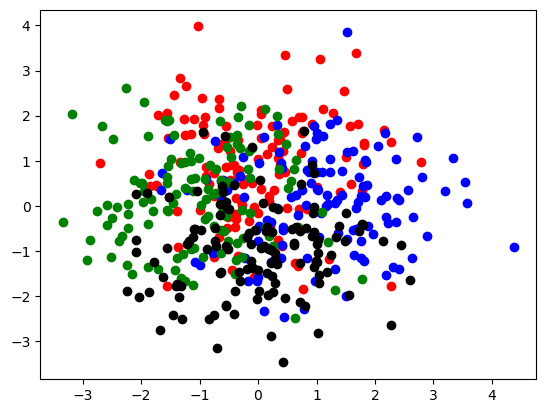

In [57]:
np.random.seed(42)
means=[[0,1],[1,0],[-1,0],[0,-1]]
cov=[[1,0],[0,1]]

samples_x=[]
samples_y=[]
labels=[]
for i in range(500):
    a=np.random.choice(list(range(4)),1)
    rv = multivariate_normal.rvs(means[a[0]], cov, size=1)
    samples_x.append(rv[0])
    samples_y.append(rv[1])
    labels.append(a[0])
samples=np.column_stack((samples_x,samples_y))
colors=["red","blue","green","black"]
for i in range(4):
    indices=list(filter(lambda x:labels[x]==i,list(range(len(samples_x)))))
    plot_x=[samples_x[j] for j in indices]
    plot_y=[samples_y[j] for j in indices]
    plt.scatter(plot_x,plot_y,c=colors[i])

plt.show()

We used multiple runs technique to decrease the effect of initialization of centroids. We run the k-means for an amount given in "runs" parameter and return the best clustering in terms of SSE(sum of squared errors). There will be 2 plots after the below cell is run. First one is colored to show original distributions and the second one is colored to show clustering.

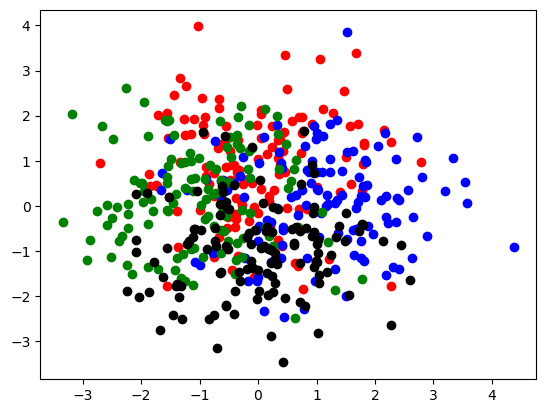

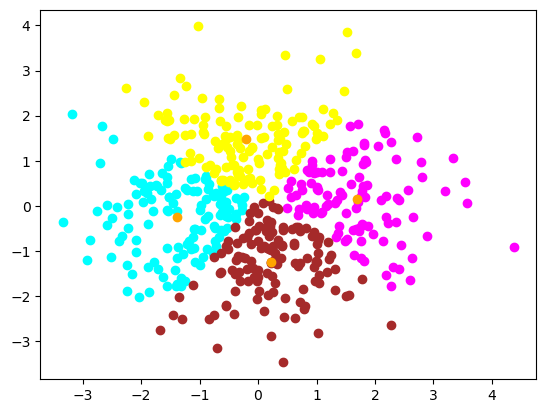

In [58]:



def dist(x,y):
    return np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)
 

def k_means(points,k,runs):
    final_assignments=[]
    final_centroids=[]
    for run in range(runs):
        changed=True
        centroids=points[np.random.choice(points.shape[0], k, replace=False)]
        assignments=[0 for i in range(len(points))]
        assignments_old=[]
        min_sse=1e10
        
        while(changed==True):

            assignments_old=assignments.copy()
            for j in range(len(points)):
                distance_to_centroids=[dist(points[j],centroids[i]) for i in range(k)]
                assignments[j]=np.argmin(distance_to_centroids)

            if (assignments==assignments_old):
                changed=False

           
            for a in range(k):
                summ=(0,0)
                count=0
                for b in range(len(points)):
                    if(assignments[b]==a):
                        summ+=points[b]
                        count+=1
                centroids[a]=summ/count
        curr_sse=0
        for m in range(len(points)):
            curr_sse+=dist(points[m],centroids[assignments[m]])**2
        if(curr_sse < min_sse):
            curr_sse = min_sse
            final_assignments = assignments
            final_centroids = centroids
        
    return [final_assignments, final_centroids]

output=k_means(samples,4,20)
assignments=output[0]


colors=["red","blue","green","black"]
for i in range(4):
    indices=list(filter(lambda x:labels[x]==i,list(range(len(samples_x)))))
    plot_x=[samples_x[j] for j in indices]
    plot_y=[samples_y[j] for j in indices]
    plt.scatter(plot_x,plot_y,c=colors[i])

plt.show()

colors2=["cyan","magenta","brown","yellow"]
for i in range(4):
    indices=list(filter(lambda x:assignments[x]==i,list(range(len(samples_x)))))
    plot_x=[samples_x[j] for j in indices]
    plot_y=[samples_y[j] for j in indices]
    plt.scatter(plot_x,plot_y,c=colors2[i])

plot_x=[output[1][i][0] for i in range(4)]
plot_y=[output[1][i][1] for i in range(4)]
plt.scatter(plot_x,plot_y,c="orange")

plt.show()



As we can see, the clustering can't recreate the original distributions. However, this is normal because original distributions are not distinguishable. Let's say we have a point (0.5,0.5) which can come from the first distribution or the second distribution equally likely. If we reduce the covariance matrix to 1/10th of the original, we get distinguishable distributions which we implement below.

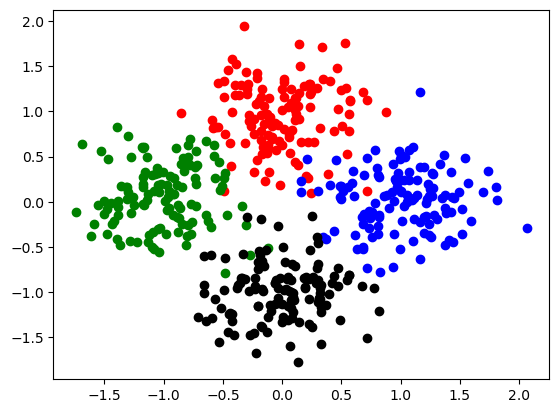

In [59]:
np.random.seed(42)
means=[[0,1],[1,0],[-1,0],[0,-1]]
cov=[[0.1,0],[0,0.1]]

samples_x=[]
samples_y=[]
labels=[]
for i in range(500):
    a=np.random.choice(list(range(4)),1)
    rv = multivariate_normal.rvs(means[a[0]], cov, size=1)
    samples_x.append(rv[0])
    samples_y.append(rv[1])
    labels.append(a[0])
samples=np.column_stack((samples_x,samples_y))
colors=["red","blue","green","black"]
for i in range(4):
    indices=list(filter(lambda x:labels[x]==i,list(range(len(samples_x)))))
    plot_x=[samples_x[j] for j in indices]
    plot_y=[samples_y[j] for j in indices]
    plt.scatter(plot_x,plot_y,c=colors[i])

plt.show()

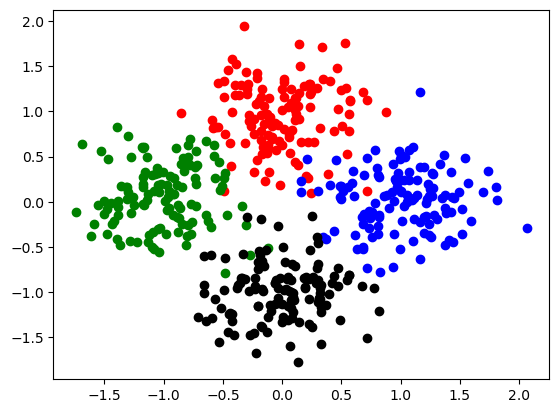

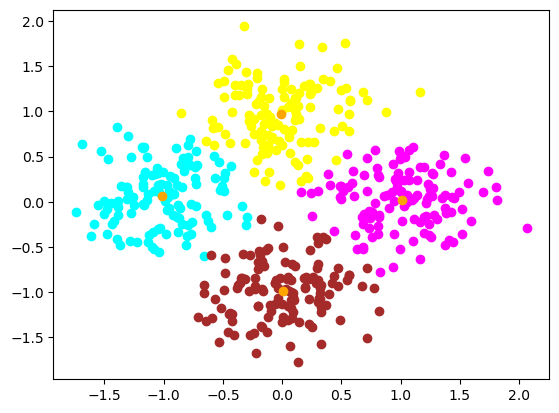

In [60]:
output=k_means(samples,4,20)
assignments=output[0]


colors=["red","blue","green","black"]
for i in range(4):
    indices=list(filter(lambda x:labels[x]==i,list(range(len(samples_x)))))
    plot_x=[samples_x[j] for j in indices]
    plot_y=[samples_y[j] for j in indices]
    plt.scatter(plot_x,plot_y,c=colors[i])

plt.show()

colors2=["cyan","magenta","brown","yellow"]
for i in range(4):
    indices=list(filter(lambda x:assignments[x]==i,list(range(len(samples_x)))))
    plot_x=[samples_x[j] for j in indices]
    plot_y=[samples_y[j] for j in indices]
    plt.scatter(plot_x,plot_y,c=colors2[i])

plot_x=[output[1][i][0] for i in range(4)]
plot_y=[output[1][i][1] for i in range(4)]
plt.scatter(plot_x,plot_y,c="orange")

plt.show()

As we can see, the clustering can recreate the original distributions almost exactly. Even the centroids are very close to the actual means.